# Case Study: Multiclass Classification Model for Product Descriptions
## Irem Arici

#### Installing dependencies & libraries

In [59]:
import pandas as pd
import numpy as np
import string
from string import digits
import nltk
from nltk import punkt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import seaborn as sns

#### Loading the category and explanation datasets

In [60]:
category = pd.read_table("Product_Categories.txt", sep=";", header=None, on_bad_lines="skip")
explanation = pd.read_table("Product_Explanation.txt", sep=";", header=None, on_bad_lines="skip")

In [61]:
print(f"The length of the category dataframe is {len(category)}")
print("\n")
print(f"The length of the explanation dataframe is {len(explanation)}")

The length of the category dataframe is 1782


The length of the explanation dataframe is 1468


## 1. Data Preprocessing and EDA

### 1.1. Category dataset exploration and preprocessing

In [62]:
category.head(30)

,0,1
0,116,TELEKOM > AKILLI TELEFON
1,462,Bilgisayar > Taşınabilir Bilgisayarlar
2,1286,Cep Telefonları > APPLE
3,1290,Cep Telefonları > SAMSUNG
4,1300,Ev Elektroniği > Televizyonlar > SAMSUNG
5,1665,Bilgisayar > Bilgisayar Parçaları > Monitör > ...
6,2021,Cep Telefonu > Sony
7,2485,PC / Monitör > Monitör
8,2495,Bilgisayar Ürünleri > Veri Depolama > Taşınabi...
9,2503,Fotoğraf / Elektronik > Dijital Fotoğraf Makinesi


In [63]:
# splitting by greater than symbol to get individual columns for each category
# note that each entry does not have equal numbers of subcategories so the first
# two categories are most useful for classification
df_category = category[1].str.split(">", n=3, expand=True)

# renaming the column names for clarification
df_category = df_category.rename(columns={0: "cat1", 1: "cat2", 2: "cat3", 3: "cat4"})

#### Handling the missing values

In [64]:
# missing values in the dataset
print(df_category.info())
print("\n")
print(df_category.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1782 entries, 0 to 1781
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   cat1    1753 non-null   object
 1   cat2    1676 non-null   object
 2   cat3    1217 non-null   object
 3   cat4    467 non-null    object
dtypes: object(4)
memory usage: 55.8+ KB
None


cat1      29
cat2     106
cat3     565
cat4    1315
dtype: int64


In [65]:
# even though as seen above there are many missing values,
# the first two categories are more important for classification
# so only first categories have been cleared off null values
df_category = df_category.dropna(subset=["cat1","cat2"])

In [66]:
# there are 195 unique category names as of now, too much.
cat_names = df_category["cat1"].unique()
print(cat_names)
print("\n")
print(f"The length of category names is {len(cat_names)}") 

['TELEKOM ' 'Bilgisayar ' 'Cep Telefonları ' 'Ev Elektroniği '
 'Cep Telefonu ' 'PC / Monitör ' 'Bilgisayar Ürünleri '
 'Fotoğraf / Elektronik ' 'Küçük Ev Aletleri ' 'Led Tv ' 'Android Tablet '
 'OEM ' 'KASA ' 'Dijital Yaşam ' 'Telefon ' 'Elektronik/TV ' 'MP3 '
 'Uydu Alıcıları ' 'Ev / Bakım ' 'TV & Görüntü Sistemleri ' 'Monitör '
 'Power Supply ' 'Taşınabilir Diskler ' 'Flash Bellek '
 'Isıtma & Soğutma ' 'Foto & Kamera ' 'SES VE GÖRÜNTÜ ' 'Telefonlar '
 'Ev Elektroniği & TV ' 'Oyun - Hobi ' 'Antenler / Kablolar '
 'Müzik Çalar ' 'Bilgisayar Bileşenleri '
 'Beyaz Eşya & Elektrikli Ev Aletleri ' 'Çevre Birimleri '
 'Network Ürünleri ' 'Tv Aksesuar ' 'Hesap Makineleri '
 'Slr Fotoğraf Makinesi ' 'Oyun Konsolları ' 'Bilg.Parçaları '
 'Tüketici Elektroniği ' 'Ultrabook ' 'Yağlı Radyatörler ' 'Yazılım '
 'OEM Ürünleri ' 'Hardiskler ' 'Bilgi Teknolojileri ' 'Televizyon '
 'Monitörler ' 'Fotoğraf-Kamera ' 'Yazıcı '
 'Elektronik / Tüketici Elektroniği ' 'Foto&Kamera ' 'Elektronik '
 'Mobilya 

#### Cleaning string values

In [67]:
# lowercasing the category strings for machine easy-read and standardization purposes
for col in df_category.columns:
    df_category[col] = df_category[col].str.lower()
    
df_category.head()

,cat1,cat2,cat3,cat4
0,telekom,akilli telefon,None,None
1,bilgisayar,taşınabilir bilgisayarlar,None,None
2,cep telefonları,apple,None,None
3,cep telefonları,samsung,None,None
4,ev elektroniği,televizyonlar,samsung,None


In [68]:
# similarly, removing punctuation chars for ease
punctuation = string.punctuation

def remove_punct(text):
    return text.translate(str.maketrans('', '', punctuation))

df_category["cat1"] = df_category["cat1"].apply(lambda text: remove_punct(text))

df_category["cat1"]

0                        telekom 
1                     bilgisayar 
2                cep telefonları 
3                cep telefonları 
4                 ev elektroniği 
                  ...            
1757    bilgisayar tablet yazıcı 
1758          toner kartuş şerit 
1759          toner kartuş şerit 
1760          toner kartuş şerit 
1761          toner kartuş şerit 
Name: cat1, Length: 1676, dtype: object

### Since there are way too many categories for classification, it should be downsized to a manageable number of categories.
#### Below, I will only consider categories with >= 3 values for pragmatic reasons

In [69]:
cat_value_count = df_category['cat1'].value_counts()

cat_value = cat_value_count[cat_value_count >= 3]

# categories with >= 3 occurences are included in the new dataframe
df_cat = df_category[df_category['cat1'].isin(cat_value.index)]

df_cat

,cat1,cat2,cat3,cat4
0,telekom,akilli telefon,None,None
1,bilgisayar,taşınabilir bilgisayarlar,None,None
2,cep telefonları,apple,None,None
3,cep telefonları,samsung,None,None
4,ev elektroniği,televizyonlar,samsung,None
...,...,...,...,...
1757,bilgisayar tablet yazıcı,bilgisayar bileşenleri,power supply,None
1758,toner kartuş şerit,kartuş,None,None
1759,toner kartuş şerit,kartuş,None,None
1760,toner kartuş şerit,kartuş,None,None


In [70]:
# there are 88 categories now (they are raw, duplicates, etc.)
cat_value

cat1
bilgisayar                      462
bilgisayar ürünleri              71
bilgisayar bileşenleri           70
aksesuar ürünleri                66
telefon                          64
                               ... 
ses  görüntü ürünleri             3
fotoğraf makinesi ve kamera       3
ev elektroniği  tv                3
beyaz eşya                        3
monitörler                        3
Name: count, Length: 88, dtype: int64

In [71]:
df_cat["cat1"].unique()

array(['telekom ', 'bilgisayar ', 'cep telefonları ', 'ev elektroniği ',
       'cep telefonu ', 'pc  monitör ', 'bilgisayar ürünleri ',
       'fotoğraf  elektronik ', 'küçük ev aletleri ', 'led tv ', 'oem ',
       'dijital yaşam ', 'telefon ', 'elektroniktv ', 'mp3 ',
       'ev  bakım ', 'tv  görüntü sistemleri ', 'monitör ',
       'isıtma  soğutma ', 'foto  kamera ', 'ses ve görüntü ',
       'telefonlar ', 'ev elektroniği  tv ', 'oyun  hobi ',
       'antenler  kablolar ', 'bilgisayar bileşenleri ',
       'çevre birimleri ', 'network ürünleri ', 'tv aksesuar ',
       'bilgparçaları ', 'tüketici elektroniği ', 'yazılım ',
       'oem ürünleri ', 'bilgi teknolojileri ', 'televizyon ',
       'monitörler ', 'yazıcı ', 'fotokamera ', 'elektronik ',
       'aksesuar ürünleri ', 'ses  görüntü ürünleri ', 'dizüstü ',
       'oyun dünyası ', 'tüketim ürünleri ', 'oem  çevre birimleri ',
       'tüketim malzemeleri ', 'oyun  oyun konsolu ', 'fotoğraf  video ',
       'çevre birimler ',

#### There are many categories, even with the restrictions, so I have merged some categories and standardize naming for similar/same category of products. So, I have created a dictionary for category names and grouped them to lower the category amount. Then, I have replaced the category names for consistency.

In [72]:
cat_dict = {
    "tv ses ": "televizyon",
    "oem ": "bilgisayar bileşenleri",
    "oem  çevre birimleri ": "bilgisayar bileşenleri",
    "oem ürünleri ": "bilgisayar bileşenleri",
    "mouse ":"bilgisayar bileşenleri",
    "bilgparçaları ":"bilgisayar bileşenleri", 
    "çevre birimleri ": "bilgisayar bileşenleri",
    "bilgisayar bileşenleri ": "bilgisayar bileşenleri",
    "soğutucufan ":"bilgisayar bileşenleri",
    "i̇nternet  ağ ürünleri ": "bilgi teknolojileri",
    "bilgisayar ürünleri ": "bilgisayar",
    "dizüstü ": "bilgisayar",
    "bi̇lgi̇sayar ": "bilgisayar",
    "bilgisayar ": "bilgisayar",
    "bilgisayarlar ": "bilgisayar",
    "kişisel bilgisayarlar ": "bilgisayar",
    "oto aks  navigasyon ": "otomobil",
    "oto ses görüntü ": "otomobil",
    "cep telefonu ": "telefon",
    "cep telefonları ": "telefon",
    "cep telefonu ve aksesuarları ": "telefon",
    "telefonlar ": "telefon",
    "telefon  i̇letişim ": "telefon",
    "telefon ": "telefon",
    "telekom ": "telefon",
    "fotoğraf  elektronik ": "fotoğraf",
    "foto  kamera ": "fotoğraf",
    "fotokamera ": "fotoğraf",
    "fotoğraf  video ": "fotoğraf",
    "fotoğraf makinesi ve kamera ": "fotoğraf",
    "fotoğraf  kamera ": "fotoğraf",
    "foto mak  kamera ": "fotoğraf",
    "ev aletleri  yaşam ": "ev elektronik",
    "ev aletleri  elektronik ": "ev elektronik",
    "ev elektroniği ": "ev elektronik",
    "küçük ev aletleri ": "ev elektronik",
    "tüketici elektroniği ": "ev elektronik",
    "beyaz eşyaev aletleri ": "ev elektronik",
    "beyaz eşya ": "ev elektronik",
    "elektrikli ev aletleri ": "ev elektronik",
    "elektronik ": "elektronik",
    "dijital yaşam ": "elektronik",
    "antenler  kablolar ": "elektronik",
    "isıtma  soğutma ": "ev elektronik",
    "elektronik ve televizyon ": "televizyon",
    "elektronik  tv ": "televizyon",
    "led tv ": "televizyon",
    "ev elektroniği  tv ": "televizyon",
    "televizyon ": "televizyon",
    "elektronik televizyon ": "televizyon",
    "elektroniktv ": "televizyon",
    "tv  görüntü sistemleri ": "televizyon",
    "tüketim ürünleri ": "tüketim ürünleri",
    "tüketim malzemeleri ": "tüketim ürünleri",
    "ev  bakım ": "tüketim ürünleri",
    "kişisel bakım  sağlık ": "kişisel bakım",
    "yazıcı ": "baskı",
    "yazıcılar ": "baskı",
    "lazer yazıcı ": "baskı",
    "bilgisayar tablet yazıcı ": "baskı",
    "toner kartuş şerit ": "baskı",
    "baskı ürünleri ": "baskı",
    "aksesuar ": "aksesuar",
    "sarf ": "aksesuar",
    "aksesuar  sarf malz ": "aksesuar",
    "tv aksesuar ": "aksesuar",
    "aksesuar ürünleri ": "aksesuar",
    "çevre birimler ": "çevre birimleri",
    "mürekkep kartuşları ": "baskı",
    "oyun ve oyun konsolları ": "oyun",
    "oyun  hobi ": "oyun",
    "oyun dünyası ": "oyun",
    "oyun  oyun konsolu ": "oyun",
    "hobi  oyun konsolu ": "oyun",
    "hobi  oyun konsolları ": "oyun",
    "hobi  oyun  müzik ": "oyun",
    "oyun ve oyun konsolu ": "oyun",
    "yazılım ": "yazılım",
    "bilgi teknolojileri " : "bilgi teknolojileri",
    "network ürünleri ": "bilgi teknolojileri",
    "ağ ürünleri ": "bilgi teknolojileri",
    "veri depolama ": "bilgi teknolojileri", 
    "ağ ürünleri ": "bilgi teknolojileri",
    "i̇nternet  ağ ürünleri ": "bilgi teknolojileri",
    "tv  ses ": "ses ve görüntü",
    "ses ve görüntü ": "ses ve görüntü",
    "mp3 ": "ses ve görüntü",
    "ses  görüntü ürünleri ": "ses ve görüntü",
    "monitör ": "ses ve görüntü",
    "monitörler ": "ses ve görüntü",
    "pc  monitör ": "ses ve görüntü",
}

df_cat["cat0"] = df_cat["cat1"].replace(cat_dict)

/var/folders/c2/jf3vrykn32d76fpp0jft_ndw0000gn/T/ipykernel_7934/1977868599.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cat["cat0"] = df_cat["cat1"].replace(cat_dict)


#### Below is the new category names, counts and length.

In [73]:
print("The new category names and values are:", "\n" ,df_cat["cat0"].value_counts())
print("\n")
print("New category names' length is",len(df_cat["cat0"].unique()))
print("\n")
print("New category value length is", df_cat["cat0"].value_counts().sum())

The new category names and values are: 
 cat0
bilgisayar                586
bilgisayar bileşenleri    187
ev elektronik             125
telefon                   106
aksesuar                  104
baskı                      79
fotoğraf                   63
oyun                       53
ses ve görüntü             44
tüketim ürünleri           42
televizyon                 39
elektronik                 36
bilgi teknolojileri        34
yazılım                    20
çevre birimleri            10
otomobil                    8
kişisel bakım               4
Name: count, dtype: int64


New category names' length is 17


New category value length is 1540


### Now, there are only 17 categories for classification. They are plotted as below.

Text(0.5, 1.0, 'Category of products and their counts')

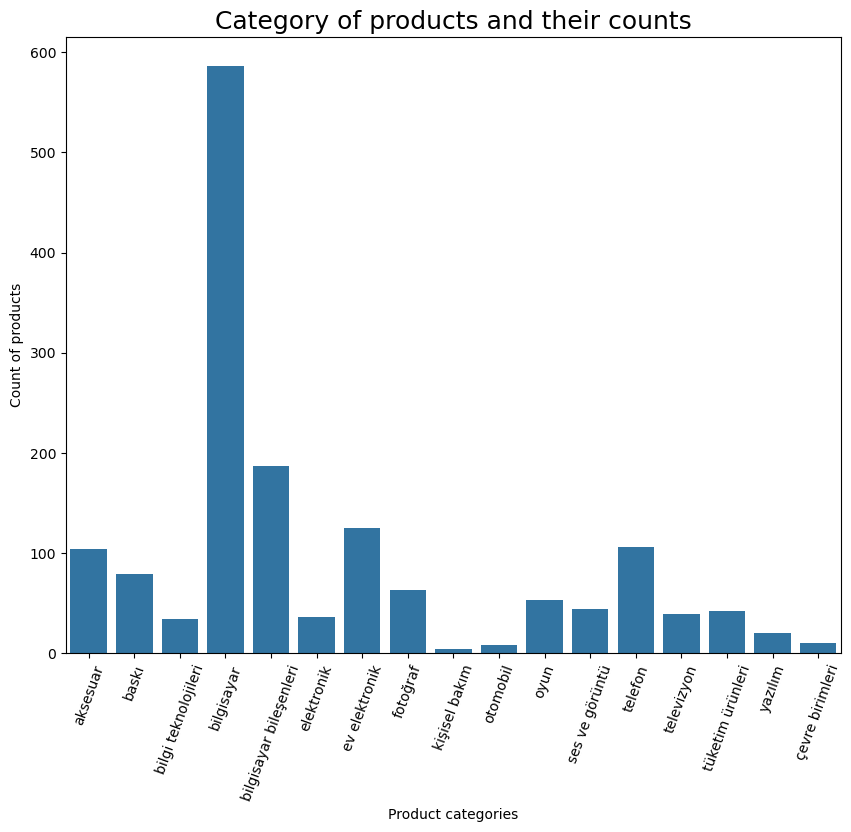

In [93]:
fig = plt.figure(figsize=(10,8))
fig = sns.countplot(x= df_cat["cat0"], order=sorted(df_cat["cat0"].unique()))
fig.set_ylabel("Count of products") 
fig.set_xlabel("Product categories")
plt.xticks(rotation = 70)
plt.title("Category of products and their counts", size = 18)

### 1.2. Explanation dataset exploration and preprocessing

In [29]:
explanation.head(10)

,0,1
0,116,NaN
1,462,HP Pavilion 11-n000nt Pentium N3540 4GB 750GB ...
2,1300,"ÖZELLİKLER Ekran Ekran Boyutu 48"" Ekran Boyutu..."
3,1665,Ürün Kodu : 40061255166 Genel Özellikler Panel...
4,2021,NaN
5,2485,Özellikler SmartControl Lite ile kolay ekran p...
6,2495,Genel Özellikler : Seagate Backup Plus ile dij...
7,2580,Ürün Hakkında Tefal GV8930 3 Ayarlı Pro Expres...
8,2838,Sony Xperia Z2 Cep Telefonu Özellikleri Genel ...
9,2842,Samsung G850 Fiyatı Özellikleri Ürün Özellikle...


In [ ]:
# renaming the columns for convention
df_explanation = explanation.rename(columns={0: "id", 1: "text"})
df_explanation.head(10)

#### Handling missing values

In [31]:
# there are 318 null values in explanation text column so we need to drop them 
print(df_explanation.isnull().sum()) 

id        0
text    318
dtype: int64


In [32]:
# now there is no null value left after dropping
df_explanation = df_explanation.dropna()
print(df_explanation.isnull().sum())

id      0
text    0
dtype: int64


#### Some preprocessing to ensure better data: lowercasing, removing punctuation, stop words, short words, and digits.

In [33]:
# lowercasing characters
for col in df_explanation.columns:
    try:
        df_explanation[col] = df_explanation[col].str.lower()
    except AttributeError:
        pass

#removing punctuation
df_explanation["text"] = df_explanation["text"].apply(lambda text: remove_punct(text))

#removing stop words
stop_words = stopwords.words("turkish")

df_explanation["text"] = [text for text in df_explanation["text"] if text not in stop_words]

#removing characters with length <= 2
def remove_small_words(text):
    return " ".join([word for word in text.split() if len(word) > 2])

df_explanation["text"] = df_explanation["text"].apply(lambda x: remove_small_words(x))

#removing numbers
def remove_digit(text):
    return text.translate(str.maketrans('', '', digits))

df_explanation["text"] = df_explanation["text"].apply(lambda text: remove_digit(text))

df_explanation.head(50)

,id,text
1,462,pavilion nnt pentium n gb gb dokunmatik win k...
2,1300,özelli̇kler ekran ekran boyutu ekran boyutu cm...
3,1665,ürün kodu genel özellikler panel tipi led ekr...
5,2485,özellikler smartcontrol lite ile kolay ekran p...
6,2495,genel özellikler seagate backup plus ile dijit...
7,2580,ürün hakkında tefal gv ayarlı pro express tota...
8,2838,sony xperia cep telefonu özellikleri genel öze...
9,2842,samsung g fiyatı özellikleri ürün özelliklerig...
10,4376,samsung galaxy alpha g beyaz açıklaması akıllı...
11,4936,tefal gv pro express buhar kazanlı ütü tefal g...


In [34]:
# as of now there are 1150 values in both id and text columns
df_explanation.count()

id      1150
text    1150
dtype: int64

#### IMPORTANT: Shapes are not compatible as a result of the data cleaning process, so I had to drop some explanation data (randomly) to match them shapewise.

In [35]:
len(df_cat["cat0"]) # length = 1137

1540

In [36]:
len(df_explanation["text"]) # length = 1150

1150

In [37]:
np.random.seed(10)

remove_n = len(df_cat["cat0"]) - len(df_explanation["text"])
drop_indices = np.random.choice(df_cat.index, remove_n, replace=False)
df_cat = df_cat.drop(drop_indices)

In [38]:
len(df_cat["cat0"]) # new length is 1137, now the same with df_explanation

1150

## 2. Model building

In [44]:
import pickle
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils.class_weight import compute_class_weight

### Preparing the training and test data: tokenization, text to seq, label encoding:

In [ ]:
# geting 10000 most frequently used words
num_words = 10000

tokenizer = Tokenizer() 

# saving tokenizer
with open("turkish_tokenizer.pickle", "wb") as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
# load tokenizer
with open("turkish_tokenizer.pickle", "rb") as handle:
    turkish_tokenizer = pickle.load(handle)

# converting text to sequences & padding
X = turkish_tokenizer.texts_to_sequences(df_explanation["text"])
max_length = 300
X = pad_sequences(X, maxlen=max_length, padding="post")

# encoding category labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df_cat["cat0"])

# y to a one-hot encoded matrix
y = tf.keras.utils.to_categorical(y)

#### Train-test split of data

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 2.1. LSTM model

In [47]:
model = Sequential()

# for semantic purposes, embedding layer is appropriate given we deal with descriptions
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim = 1000, input_length= max_length,
                   mask_zero=True))

# dropout to prevent overfitting and improve generalization
model.add(SpatialDropout1D(0.2)) 

# dropout again. also, lstm is great with sequential data architecture
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))

# used 17 since it is the amount of categories
model.add(Dense(17, activation="softmax"))

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy", "mse"])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 1000)         1000      
                                                                 
 spatial_dropout1d (Spatial  (None, 300, 1000)         0         
 Dropout1D)                                                      
                                                                 
 lstm (LSTM)                 (None, 100)               440400    
                                                                 
 dense (Dense)               (None, 17)                1717      
                                                                 
Total params: 443117 (1.69 MB)
Trainable params: 443117 (1.69 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


#### Model summary

In [ ]:
print(model.summary())

#### Model fitting

In [48]:
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
23/23 [==============================] - 19s 777ms/step - loss: 2.8253 - accuracy: 0.3641 - mse: 0.0553 - val_loss: 2.8156 - val_accuracy: 0.4185 - val_mse: 0.0552
Epoch 2/20
23/23 [==============================] - 18s 774ms/step - loss: 2.8090 - accuracy: 0.3791 - mse: 0.0552 - val_loss: 2.7984 - val_accuracy: 0.4185 - val_mse: 0.0551
Epoch 3/20
23/23 [==============================] - 18s 775ms/step - loss: 2.7929 - accuracy: 0.3791 - mse: 0.0551 - val_loss: 2.7817 - val_accuracy: 0.4185 - val_mse: 0.0550
Epoch 4/20
23/23 [==============================] - 17s 760ms/step - loss: 2.7774 - accuracy: 0.3791 - mse: 0.0550 - val_loss: 2.7650 - val_accuracy: 0.4185 - val_mse: 0.0549
Epoch 5/20
23/23 [==============================] - 18s 770ms/step - loss: 2.7617 - accuracy: 0.3791 - mse: 0.0548 - val_loss: 2.7489 - val_accuracy: 0.4185 - val_mse: 0.0548
Epoch 6/20
23/23 [==============================] - 18s 770ms/step - loss: 2.7468 - accuracy: 0.3791 - mse: 0.0547 - val_loss

### Model performance metrics

In [49]:
# model evaluation
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

8/8 [==============================] - 1s 166ms/step


In [50]:
labels = list(range(len(label_encoder.classes_)))
print(classification_report(y_true, y_pred_classes, labels=labels, target_names=label_encoder.classes_))
accuracy = accuracy_score(y_true, y_pred_classes)
print(f"Accuracy: {(accuracy * 100)}")

                        precision    recall  f1-score   support

              aksesuar       0.00      0.00      0.00        11
                 baskı       0.00      0.00      0.00        13
   bilgi teknolojileri       0.00      0.00      0.00         9
            bilgisayar       0.35      1.00      0.52        81
bilgisayar bileşenleri       0.00      0.00      0.00        32
            elektronik       0.00      0.00      0.00         5
         ev elektronik       0.00      0.00      0.00        22
              fotoğraf       0.00      0.00      0.00        10
         kişisel bakım       0.00      0.00      0.00         0
              otomobil       0.00      0.00      0.00         1
                  oyun       0.00      0.00      0.00         7
        ses ve görüntü       0.00      0.00      0.00        10
               telefon       0.00      0.00      0.00        14
            televizyon       0.00      0.00      0.00         4
      tüketim ürünleri       0.00      

/Users/iremarici/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/iremarici/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/iremarici/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/iremarici/anacond

### Before skipping to interface building...
---
The model is indeed behaving worse than expected. This step required too much manipulation: changing model parameters, model architecture, ensuring data is okay, weighting classes and such. Unfortunately, probably due to the nature of dataset, the model performance did not improve. 

Dataset is ambiguous, the categories are not clear, and there is an inbalance of products category-wise. I have repeatedly improve input data yet there were little to no improvement in the model performance.

## 3. Building the interface for inference

In [51]:
import customtkinter as ctk
import tkinter as tk

In [52]:
ctk.set_appearance_mode("dark")
ctk.set_default_color_theme("dark-blue")

In [ ]:
root = ctk.CTk()
root.geometry("500x450")

# the infer function is what makes prediction possible.
# explanation data as raw is given and processed through the model.
def infer():
    input_text = text_widget.get("1.0", tk.END).strip()
    input_seq = tokenizer.texts_to_sequences([input_text])
    input_padded = pad_sequences(input_seq, maxlen=max_length, padding="post")
    prediction = model.predict(input_padded)
    predicted_class = label_encoder.inverse_transform(np.argmax(prediction, axis=1))
    result_label.configure(text=f"Predicted Category: {predicted_class[0]}")
    
# this function makes it easier to use interface. instead of grabbing a description
# from the dataset, this step retrieves a random description every time.
def random_exp():
    random_idx = np.random.randint(len(df_explanation))
    random_text = df_explanation['text'].iloc[random_idx]
    text_widget.delete("1.0", tk.END)
    text_widget.insert(tk.END, random_text)
    
frame = ctk.CTkFrame(master=root)
frame.pack(pady=20, padx=60, fill= "both", expand = True)

label = ctk.CTkLabel(master = frame, text = "Product category prediction")
label.pack(pady = 12, padx = 10)

entry_frame = ctk.CTkFrame(master=frame)
entry_frame.pack(pady=12, padx=10, fill="both", expand=True)

text_widget = tk.Text(master=entry_frame, height=10, wrap=tk.WORD)
text_widget.pack(side="left", fill="both", expand=True, padx=10)

button1 = ctk.CTkButton(master= frame, text="Random explanation", command=random_exp)
button1.pack(pady = 12, padx=10)

button = ctk.CTkButton(master = frame, text = "Predict", command = infer)
button.pack(pady = 12, padx = 10)

frame1 = ctk.CTkFrame(master=root)
frame1.pack(pady=20, padx=60, fill="both", expand=True)

result_label = ctk.CTkLabel(master=frame1, text = "Click on predict to see result")
result_label.pack(pady=12, padx=10)

root.mainloop()

## Final remarks
---
This project has been a challenge, and I have enjoyed applying my knowledge practically. Yet, since I have almost no idea of containerization, even though I have repeatedly tried to deploy, unfortunately I was not successful. 

Moreover, I would wish to present a more accurate and reliable model, but to my current practical skills, I think I have tried my best to improve the model and data. Having more time would help me to ensure all deliverables are submitted as expected.

At this moment, **this model is not containerized and deployed**. Regardless, I will also attach my Dockerfile and attemps to my repo to show them.

Thanks,

Irem.